<a href="https://colab.research.google.com/github/hakuban-create/Chest_xray_Project_4/blob/Khali_branch/xrayv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Dependencies to Visualize the model
%matplotlib inline
from IPython.display import Image, SVG
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)


In [3]:
# Filepaths, numpy, and Tensorflow
import os
import cv2
from google.colab import drive
import numpy as np
import tensorflow as tf

In [4]:
# Sklearn scaling
from sklearn.preprocessing import MinMaxScaler

In [5]:
# Keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from io import BytesIO
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, optimizers

In [6]:
drive.mount('/content/drive')

data_directory_path = os.path.join("/content/drive/MyDrive/chest_xray")
train_directory_path = os.path.join(data_directory_path, "train")
train_normal_path = os.path.join(train_directory_path, "NORMAL")
train_pneumonia_path = os.path.join(train_directory_path, "PNEUMONIA")

test_directory_path = os.path.join(data_directory_path, "test")
test_normal_path = os.path.join(test_directory_path, "NORMAL")
test_pneumonia_path = os.path.join(test_directory_path, "PNEUMONIA")

val_directory_path = os.path.join(data_directory_path, "val")
val_normal_path = os.path.join(val_directory_path, "NORMAL")
val_pneumonia_path = os.path.join(val_directory_path, "PNEUMONIA")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


----- LOADING DATASETS -----

In [7]:
print(len(os.listdir(train_normal_path)))
print(len(os.listdir(train_pneumonia_path)))
print(len(os.listdir(test_normal_path)))
print(len(os.listdir(test_pneumonia_path)))
print(len(os.listdir(val_normal_path)))
print(len(os.listdir(val_pneumonia_path)))


1362
3903
234
390
8
8


In [8]:
X_train = []
y_train = []

X_test = []
y_test = []

x_val = []
y_val = []

In [9]:
# getting ready to process images with some functions
def sharpen(image):
    kernel_sharpening = np.array([[-1, -1, -1],
                                  [-1, 9, -1],
                                  [-1, -1, -1]])
    return cv2.filter2D(image, -1, kernel_sharpening)

def denoise(image, kernel_size = (3,3), sigma=0):
    return cv2.GaussianBlur(image, kernel_size, sigma)

def equalize(image):
    # Split the image into its separate color channels
    red, green, blue = cv2.split(image)

    # Equalize the histogram of each color channel
    red_equalized = cv2.equalizeHist(red)
    green_equalized = cv2.equalizeHist(green)
    blue_equalized = cv2.equalizeHist(blue)

    # Merge the equalized color channels back into a single image
    img_equalized = cv2.merge((red_equalized, green_equalized, blue_equalized))

    return img_equalized


def normalize(image):
    return image / 255.0

def resize(image):
    return cv2.resize(image, (256, 256))

def denormalize(image):
    return image * 255

def preprocess(image):
    eq_image = equalize(image)
    dn_image = denoise(image)
    sh_image = sharpen(dn_image)
    re_image = resize(sh_image)
    # no_image = normalize(re_image)
    # de_image = denormalize(no_image)
    return re_image



In [10]:
for image_file in os.listdir(val_normal_path):
  image_path = os.path.join(val_normal_path, image_file)
  image = cv2.imread(image_path)
  image = preprocess(image)
  x_val.append(image)
  y_val.append(0)

In [11]:
for image_file in os.listdir(val_pneumonia_path):
  image_path = os.path.join(val_pneumonia_path, image_file)
  image = cv2.imread(image_path)
  image = preprocess(image)
  x_val.append(image)
  y_val.append(1)

In [12]:
for image_file in os.listdir(test_normal_path):
  image_path = os.path.join(test_normal_path, image_file)
  image = cv2.imread(image_path)
  image = preprocess(image)
  X_test.append(image)
  y_test.append(0)

In [13]:
for image_file in os.listdir(test_pneumonia_path):
  image_path = os.path.join(test_pneumonia_path, image_file)
  image = cv2.imread(image_path)
  image = preprocess(image)
  X_test.append(image)
  y_test.append(1)

In [14]:
for image_file in os.listdir(train_normal_path):
  image_path = os.path.join(train_normal_path, image_file)
  image = cv2.imread(image_path)
  image = preprocess(image)
  X_train.append(image)
  # X_train.append(image.astype('uint8'))
  y_train.append(0)

In [15]:
for image_file in os.listdir(train_pneumonia_path):
  image_path = os.path.join(train_pneumonia_path, image_file)
  image = cv2.imread(image_path)
  image = preprocess(image)
  X_train.append(image)
  y_train.append(1)

In [16]:
# Convert lists to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
x_val = np.array(x_val)
y_val = np.array(y_val)

In [17]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (5265, 256, 256, 3)
y_train shape: (5265,)
X_test shape: (624, 256, 256, 3)
y_test shape: (624,)
x_val shape: (16, 256, 256, 3)
y_val shape: (16,)


In [18]:
y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

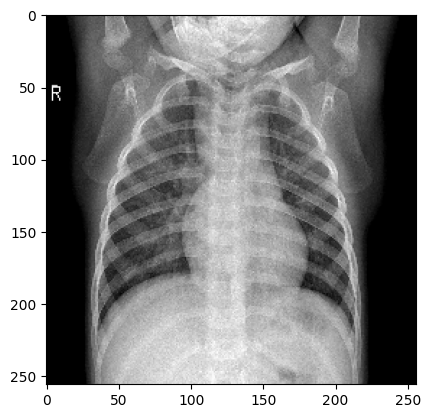

In [19]:
# Plot the first image from the dataset
plt.imshow(X_train[0], cmap=plt.cm.Greys)

------BUILDING MODEL #1-------

In [20]:

# model = models.Sequential([
#       Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Conv2D(32, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dense(512, activation='relu'),
#     layers.Dropout(0.5),  # Dropout for regularization
#     layers.Dense(1, activation='softmax')  # Output layer with softmax activation for multi-class classification
# ])

In [21]:
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

In [22]:
# model.fit(
#     X_train,
#     y_train,
#     epochs=10,
#     shuffle=True,
#     verbose=2
# )

In [23]:
# model_loss, model_accuracy = model.evaluate(X_test, y_test, verbose=2)
# print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

------- HYPERPARAMETER TUNING---------

In [24]:
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation', ['relu'])

    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
                                                     min_value=5,
                                                     max_value=10,
                                                     step=2),
                                       activation="relu"
                                      ))
    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 3)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
                                                         min_value=1,
                                                         max_value=10,
                                                         step=2),
                                           activation=activation))
    nn_model.add(tf.keras.layers.Flatten())
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

    return nn_model

In [25]:
!pip install keras_tuner
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.4 MB/s eta 0:00:00


In [26]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train,y_train,epochs=20,validation_data=(X_test,y_test))

Trial 60 Complete [00h 01m 37s]
val_accuracy: 0.8108974099159241

Best val_accuracy So Far: 0.8461538553237915
Total elapsed time: 00h 26m 59s


In [ ]:
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

In [ ]:
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

------- HYPERPARAMETER TUNING END---------

------BUILDING MODEL #2-------

In [ ]:
# from tensorflow.keras import models, layers, regularizers

# # Define the model
# model = models.Sequential()

# # Convolutional layers
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))

# # Flatten layer
# model.add(layers.Flatten())

# # Dense layers with dropout and L2 regularization
# model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# model.add(layers.Dropout(0.5))

# # Output layer
# model.add(layers.Dense(1, activation='sigmoid'))

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Print the model summary
# model.summary()

In [ ]:
# model.fit(
#     X_train,
#     y_train,
#     epochs=10,
#     shuffle=True,
#     verbose=2
# )

In [31]:
# model_loss, model_accuracy = model.evaluate(X_test, y_test, verbose=2)
# print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")